# Using PyTorch Lightning and MLFlow with Rockpool

## Set up task

In [1]:
import tonic.transforms as t

In [2]:
import tonic
from tonic.datasets import SHD, SMNIST
from tonic import CachedDataset
from tonic.transforms import Compose, ToFrame, Downsample, NumpyAsType, Repeat
from tonic.collation import PadTensors
from torch.utils.data import DataLoader
import torch
import numpy as np

from rockpool import TSEvent
from rockpool.parameters import Constant

import matplotlib.pyplot as plt

from dataclasses import dataclass, field

In [3]:
# - Define a transform to squeeze a data sample
class NumpySqueeze:
    def __call__(self, sample):
        return np.squeeze(sample)

In [4]:
# - Define time steps for input samples and the network dt
dt_sample = 1e-3
dt_snn = 10e-3

In [5]:
# - Create dataset and dataloader for Spiking Heidelberg Digits
data_transform = Compose([
    Downsample(time_factor = dt_sample, spatial_factor = 1/35),
    ToFrame((int(700 / 35), 1, 1), time_window = dt_snn / dt_sample),
    NumpySqueeze(),
    NumpyAsType(np.float32),
])

ds_train = SHD(save_to = './data', train = True, transform = data_transform)
ds_val = SHD(save_to = './data', train = False, transform = data_transform)

dl_train = DataLoader(
    ds_train,
    num_workers = 0,
    collate_fn = PadTensors(batch_first = True),
    batch_size = 64)

dl_val = DataLoader(
    ds_val,
    num_workers = 0,
    collate_fn = PadTensors(batch_first = True),
    batch_size = 64)

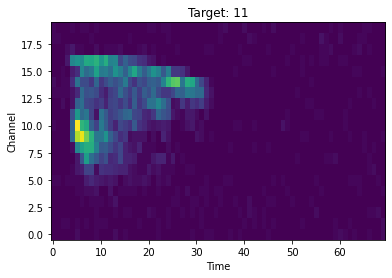

In [6]:
sample, target = ds_train[0]
plt.imshow(sample.T, aspect = 'auto', origin='lower');
plt.title(f"Target: {target}")
plt.xlabel('Time')
plt.ylabel('Channel');

In [7]:
# - Record the number of input channels
N_in = sample.shape[1]

# - Number of output classes is fixed
N_out = 20

## Define network and model

In [8]:
from rockpool.nn.modules import LIFTorch, LinearTorch
from rockpool.nn.combinators import Sequential, Residual

from torch.nn import functional as F

import pytorch_lightning as pl

import mlflow

/Users/dylanaictx/SynSense Dropbox/Dylan Muir/LiveSync/Development/rockpool_GIT/rockpool/nn/modules/__init__.py:43: UserWarning: Sinabs modules not available: 'Slayer' backend not found. Modules that rely on Sinabs-Slayer will not be available.
  warnings.warn(f"Sinabs modules not available: {err}")
/Users/dylanaictx/SynSense Dropbox/Dylan Muir/LiveSync/Development/rockpool_GIT/rockpool/utilities/__init__.py:22: UserWarning: Could not import modules: 'Brian2' backend not found. Modules that rely on Brian will not be available.
  warnings.warn(f"Could not import modules: {err}")


Could not import package: 'Brian2'backend not found. Modules that rely on Brian will not be available.
Could not import package: No module named 'iaf_nest'


/Users/dylanaictx/SynSense Dropbox/Dylan Muir/LiveSync/Development/rockpool_GIT/rockpool/nn/modules/__init__.py:63: UserWarning: NEST modules not available: 'NEST' backend not found. Modules that rely on NEST will not be available.
  warnings.warn(f"NEST modules not available: {err}")


In [9]:
N_hidden = 256

In [10]:
# - Define a PyTorch Lightning module
class Model(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.net = Sequential(
            LinearTorch((N_in, N_hidden), has_bias = False),
            LIFTorch(N_hidden, dt = dt_snn,
                     bias = Constant(0.), threshold = Constant(1.),
                     tau_syn = Constant(10e-3), tau_mem = Constant(10e-3),
                    ),
            LinearTorch((N_hidden, N_out), has_bias = False),
            LIFTorch(N_out, dt = dt_snn,
                     bias = Constant(0.), threshold = Constant(1.),
                     tau_syn = Constant(10e-3), tau_mem = Constant(10e-3),
                    ),
        ).to_torch()
        
        self._last_loss = torch.inf
    
    def forward(self, x):
        return self.net(x)
    
    def _shared_eval_step(self, batch):
        x, y = batch
        y_hat = self(x)
        y = y.unsqueeze(1).repeat(1, y_hat.shape[1])
        
        crit = F.cross_entropy(y_hat.permute(0, 2, 1), y)        
        reg = torch.mean((1 - y_hat) ** 2)
        loss = crit + reg

        self._last_loss = loss
        
        return loss
    
#     def on_train_batch_start(self, batch, batch_idx):
#         return -torch.isnan(self._last_loss).int()
    
    def training_step(self, batch, batch_idx):
        loss = self._shared_eval_step(batch)
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss = self._shared_eval_step(batch)
        self.log("val_loss", loss)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.02)

In [11]:
# - Instantiate the model
model = Model()

/Users/dylanaictx/SynSense Dropbox/Dylan Muir/LiveSync/Development/rockpool_GIT/rockpool/nn/modules/torch/lif_torch.py:209: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  to_float_tensor = lambda x: torch.tensor(x).float()


In [12]:
# - Initialize a trainer
trainer = pl.Trainer(
    callbacks = [pl.callbacks.ModelCheckpoint()],
    max_epochs=100,
)

# - Enable autologging
mlflow.pytorch.autolog()

# - Create a new MLFlow run and fit the model
with mlflow.start_run() as run:
    trainer.fit(model, dl_train, dl_val)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
2022/01/13 17:14:57 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of pytorch. If you encounter errors during autologging, try upgrading / downgrading pytorch to a supported version, or try upgrading MLflow.
2022/01/13 17:14:57 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/wavesense/lib/python3.8/site-packages/pytorch_lightning/core/memory.py:16: LightningDeprecationWarning: `pytorch_lightning.core.memory.get_memory_profile` and `pytorch_lightning.core.memory.get_gpu_memory_map` have been moved to `pytorch_lightning.utilities.memory` since v1.5 and will be removed in v1.7."
2022/01/13 17:14:57 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/wavesense/lib/python3.8/site-packages/pytorch_lightning/core/memory.py:25: LightningDeprecationWar

Validation sanity check: 0it [00:00, ?it/s]

/opt/anaconda3/envs/wavesense/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/anaconda3/envs/wavesense/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [13]:
model.net.simulation_parameters()

{'0_LinearTorch': {},
 '1_LIFTorch': {'n_synapses': 1,
  'n_neurons': 256,
  'dt': 0.01,
  'noise_std': 0.0,
  'tau_mem': tensor(0.0100),
  'tau_syn': tensor(0.0100),
  'bias': tensor(0.),
  'threshold': tensor(1.),
  'learning_window': tensor(0.5000),
  'spike_generation_fn': <function StepPWL.apply>},
 '2_LinearTorch': {},
 '3_LIFTorch': {'n_synapses': 1,
  'n_neurons': 20,
  'dt': 0.01,
  'noise_std': 0.0,
  'tau_mem': tensor(0.0100),
  'tau_syn': tensor(0.0100),
  'bias': tensor(0.),
  'threshold': tensor(1.),
  'learning_window': tensor(0.5000),
  'spike_generation_fn': <function StepPWL.apply>}}

Text(0.5, 1.0, '15')

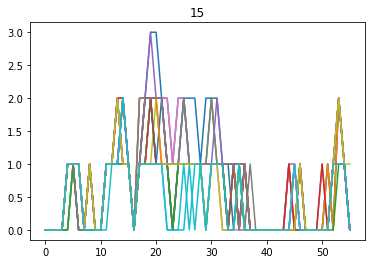

In [14]:
sample, target = ds_train[23]
plt.plot(model(torch.from_numpy(sample.reshape(1, -1, N_in))).detach().numpy().squeeze());
plt.title(target)

In [15]:
out, _, r_d = model.net.evolve(torch.from_numpy(sample.reshape(1, -1, N_in)), record = True)

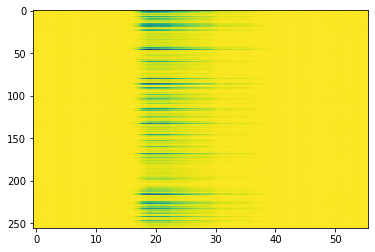

In [16]:
plt.imshow(r_d['0_LinearTorch_output'].squeeze().detach().numpy().T, aspect = 'auto')

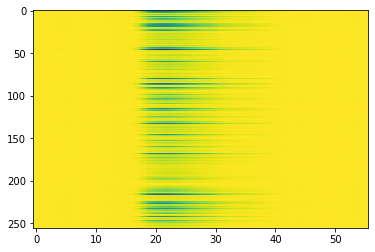

In [18]:
plt.imshow(r_d['1_LIFTorch']['vmem'].detach().numpy().squeeze().T, aspect='auto')

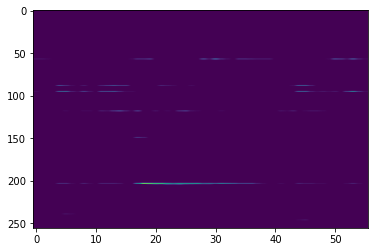

In [19]:
plt.imshow(r_d['1_LIFTorch_output'].squeeze().detach().numpy().T, aspect = 'auto')

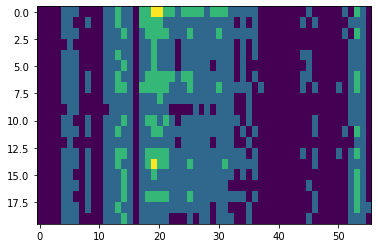

In [20]:
plt.imshow(r_d['3_LIFTorch_output'].squeeze().detach().numpy().T, aspect = 'auto')